In [1]:
# load packages
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import regex as re
import seaborn as sns
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DS4A-Project/Data/liar_dataset/'

Mounted at /content/drive


In [12]:
import glob
print(glob.glob("/drive/My Drive/*"))

[]


In [4]:
# read in raw datasets
df_train = pd.read_csv(path + 'train.tsv', sep='\t')


FileNotFoundError: ignored

In [ ]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# create indicator for fake news
df_fake['fake_flag'] = 1
df_real['fake_flag'] = 0

Raw Data EDA

In [ ]:
# combine data
df_raw = pd.concat([df_fake, df_real])

In [ ]:
df_raw

,title,text,subject,date,fake_flag
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [ ]:
TEXT_COLUMN = 'title'
text_fake = df_fake[TEXT_COLUMN]
text_real = df_real[TEXT_COLUMN]

Data composition

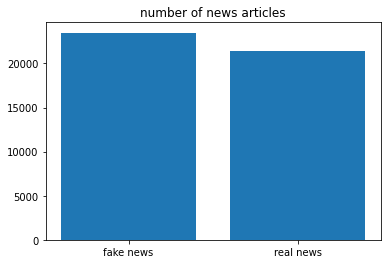

number of fake articles:  23481
number of real articles:  21417


In [ ]:
# number of fake and real data
n_fake = df_fake.shape[0]
n_real = df_real.shape[0]
plt.bar(x = [0,1], height = [n_fake, n_real], tick_label = ['fake news', 'real news'])
plt.title("number of news articles")
plt.show()
print("number of fake articles: ", n_fake)
print("number of real articles: ", n_real)

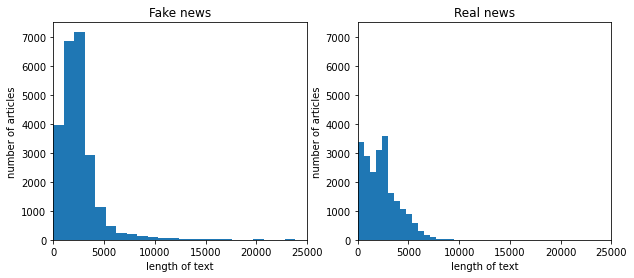

median length of fake news articles : 2166.0
median length of real news articles : 2222.0
standard deviation of length of fake news articles : 2532.8843992489196
standard deviation of length of real news articles : 1684.8357303747152


In [ ]:
# Q: Is there a significant difference in length between the real and fake news? 
# We can redo this analysis with number of words 
df_fake["text_length"] = df_fake["text"].apply(lambda x: len(x))
df_real["text_length"] = df_real["text"].apply(lambda x: len(x))

fig, axes = plt.subplots(ncols = 2, figsize = (10, 4))
axes[0].hist(df_fake["text_length"], bins = 50)
axes[0].set_title("Fake news")
axes[1].hist(df_real["text_length"], bins = 50)
axes[1].set_title("Real news")
for ax in axes.ravel(): 
  ax.set_ylim(0, 7500)
  ax.set_xlim(0, 25000)
  ax.set_xlabel('length of text')
  ax.set_ylabel('number of articles')
plt.show()

print("median length of fake news articles :", df_fake["text_length"].median())
print("median length of real news articles :", df_real["text_length"].median())
print("standard deviation of length of fake news articles :", df_fake["text_length"].std())
print("standard deviation of length of real news articles :", df_real["text_length"].std())

Real and fake news have similar median length. However, fake news has higher variability in news length.  

Top Non-Stopwords

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word.lower() for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # plt.figure(figsize=(8,6))
    # plt.title('Top Non-Stopwords')
    sns.barplot(x=y, y=x)

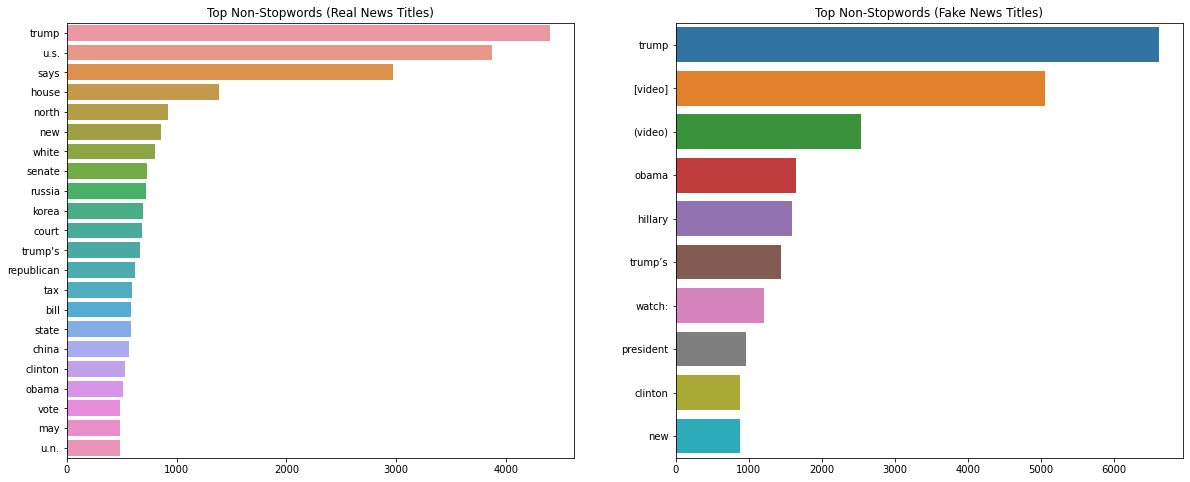

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Top Non-Stopwords (Real News Titles)')
plot_top_non_stopwords_barchart(text_real)
plt.subplot(1, 2, 2)
plt.title('Top Non-Stopwords (Fake News Titles)')
plot_top_non_stopwords_barchart(text_fake)

Top N-grams

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word.lower() for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(text, n)[:10]
    x,y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Bigrams

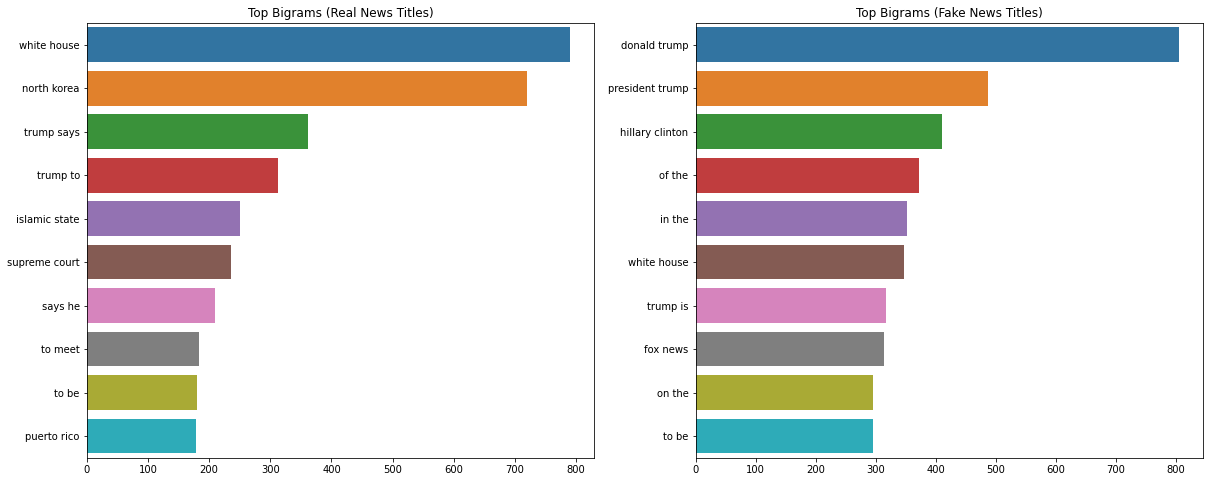

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Top Bigrams (Real News Titles)')
plot_top_ngrams_barchart(text_real, 2)
plt.subplot(1, 2, 2)
plt.title('Top Bigrams (Fake News Titles)')
plot_top_ngrams_barchart(text_fake, 2)

Trigrams

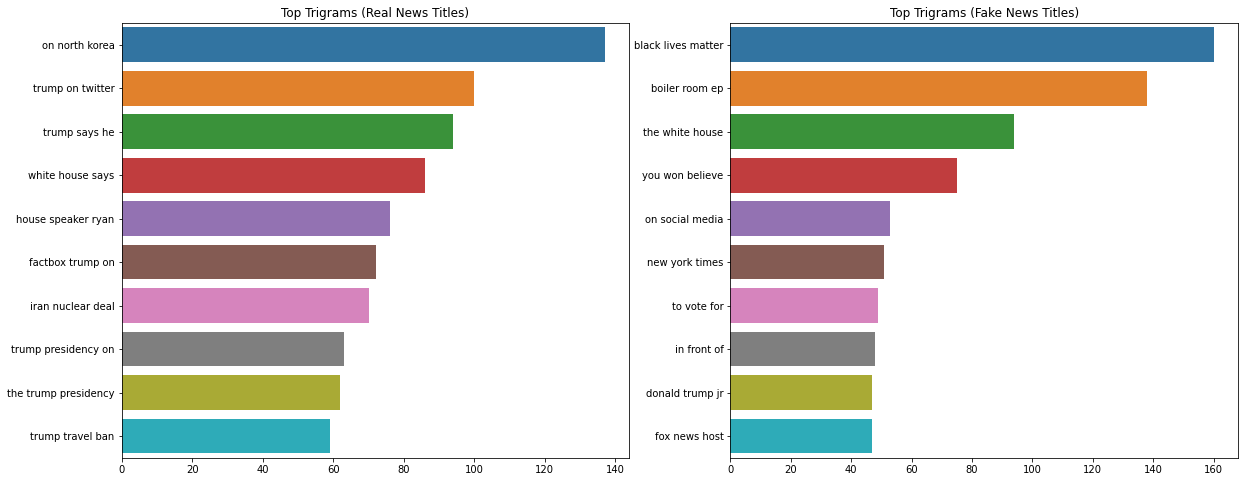

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title('Top Trigrams (Real News Titles)')
plot_top_ngrams_barchart(text_real, 3)
plt.subplot(1, 2, 2)
plt.title('Top Trigrams (Fake News Titles)')
plot_top_ngrams_barchart(text_fake, 3)

Wordclouds

In [ ]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w) > 2]

            corpus.append(words)
        return corpus
    
    corpus = _preprocess_text(text)
    
    wordcloud = WordCloud(
                background_color='white',
                stopwords=set(STOPWORDS),
                max_words=100,
                max_font_size=30, 
                scale=3,
                random_state=1)
    
    wordcloud = wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12,12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


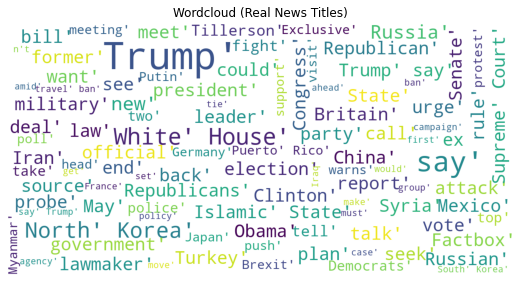

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


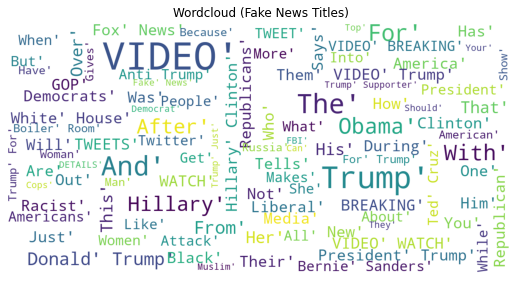

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Wordcloud (Real News Titles)')
plot_wordcloud(text_real)
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.title('Wordcloud (Fake News Titles)')
plot_wordcloud(text_fake)

Preprocessing ( In progress)

In [ ]:
import random

In [ ]:
# random fake & real articles
print("Example fake articles: ")
fake_idx = random.sample(range(df_fake.shape[0]),5)
for idx in fake_idx:
  print(df_fake.at[idx,"text"])

print("\nExample real articles: ")
real_idx = random.sample(range(df_real.shape[0]),5)
for idx in real_idx:
  print(df_real.at[idx,"text"])

Example fake articles: 
On Friday, Donald Trump decided to distract from revelations that intelligence agencies had identified the individual Russians who delivered hacked documents to Wikileaks on behalf of The Donald s  best friend  Vladimir Putin by proving to the world that what he lacks in his desire to attend intelligence briefings he makes up for in his adherence to the principle that  ratings aree everything. Wow, the ratings are in and Arnold Schwarzenegger got  swamped  (or destroyed) by comparison to the ratings machine, DJT. So much for .  Trump tweeted. Nine minutes later, he added,  being a movie star-and that was season 1 compared to season 14. Now compare him to my season 1. But who cares, he supported Kasich & Hillary. Wow, the ratings are in and Arnold Schwarzenegger got "swamped" (or destroyed) by comparison to the ratings machine, DJT. So much for .  Donald J. Trump (@realDonaldTrump) January 6, 2017Wow, the ratings are in and Arnold Schwarzenegger got "swamped" (or

Some differences between the fake and real news articles:  
  * fake news articles do not contain apostrophes, whereas real news articles contain apostrophes: ex) fake: "don t", real: "don't".  
    * We should replace apostrophes in the real articles with a space
  * real news articles contain the source in the beginning, while fake news articles contain the source at the end.  
    * This is important to address, since we don't want our model just looking at the beginning and end of text to look for news source. 
    * We can remove the source at the beginning of real news articles using regex. 
    * I removed the source at the end of the fake news by removing string appearing after the last period. This generally works, but there are still some fake news articles that contain the source. 


Text processing performed on both fake and real news articles:  
* replace any URL with word URL  
* remove twitter handles ex) @realDonaldTrump, hashtags
* remove punctuation, numbers, extra spaces
* lowercase  
* remove stop words?
* stemming / lemmatizing? : These may be required before doing tf-idf. However, we may want to keep the words as is when using RNN / LSTM / BERT type models, since these models can pick up on tone and nuances of writing.  
* combine title and text


In [ ]:
def cleanText(text):
  # replace any url with string "URL"
  text = re.sub(r"http\S+","URL", text)

  # remove twitter handles
  text = re.sub('@[^\s]+','',text)

  # remove hashtags
  text = re.sub('#[^\s]+','',text)

  # remove punctuation / symbols / numbers
  pattern = r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)

  # replace multiple spaces with single space
  text = re.sub(" +", " ", text)

  # make lowercase 
  words = text.split()
  words = [item.lower() for item in words]

  # remove stopwords
  stop = set(stopwords.words('english'))
  words = [w for w in words if w not in stop]

  # stem or lemmatize
  # porter = PorterStemmer()
  # words = [porter.stem(item) for item in words]
  #lem = WordNetLemmatizer()
  #words = [lem.lemmatize(item) for item in words]

  return words

In [ ]:
# for fake news only
# remove the string after the last punctuation marks (.!?) This will generally remove the source of the fake news
df_fake["text_cleaned"] = df_fake["text"].apply(lambda x: re.sub('@21WIRE.TV', '',x))
df_fake["text_cleaned"] = df_fake["text_cleaned"].apply(lambda x: re.sub('(?<=[\?\.\!])[^?|.|!]*$','',x))

# apply cleanText
df_fake["title_cleaned"] = df_fake["title"].apply(cleanText)
df_fake["text_cleaned"] = df_fake["text_cleaned"].apply(cleanText)

# For real news only
# remove the WSHINGTON (Reuters) type string at the beginning
df_real["text_cleaned"] = df_real["text"].apply(lambda x: re.sub("^[^-]*- ", "",x))
# replace apostrophe with a space
df_real["text_cleaned"] = df_real["text_cleaned"].apply(lambda x: re.sub(r'[\'\u2019\u02bc]'," ",x))
# apply cleanText
df_real["text_cleaned"] = df_real["text_cleaned"].apply(cleanText)
df_real["title_cleaned"] = df_real["title"].apply(cleanText)

In [ ]:
df_fake.head()

,title,text,subject,date,fake_flag,text_cleaned,title_cleaned
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, wish, americans, happy, new, y...","[donald, trump, sends, embarrassing, new, year..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,"[friday, revealed, former, milwaukee, sheriff,...","[sheriff, david, clarke, becomes, internet, jo..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,"[christmas, day, donald, trump, announced, wou...","[trump, obsessed, even, obamas, name, coded, w..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,"[pope, francis, used, annual, christmas, day, ...","[pope, francis, called, donald, trump, christm..."


In [ ]:
df_real.head()

,title,text,subject,date,fake_flag,text_cleaned,title_cleaned
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,"[head, conservative, republican, faction, us, ...","[us, budget, fight, looms, republicans, flip, ..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,"[transgender, people, allowed, first, time, en...","[us, military, accept, transgender, recruits, ..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,"[special, counsel, investigation, links, russi...","[senior, us, republican, senator, let, mr, mue..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,"[trump, campaign, adviser, george, papadopoulo...","[fbi, russia, probe, helped, australian, diplo..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,"[president, donald, trump, called, us, postal,...","[trump, wants, postal, service, charge, much, ..."


In [ ]:
# combine fake & real
df = pd.concat([df_fake, df_real])

# combine cleaned title & text
df["title_text_cleaned"] = df["title_cleaned"] + df["text_cleaned"] 

In [ ]:
# add stemmed version 
porter = PorterStemmer()
df["title_text_stemmed"] = df["title_text_cleaned"].apply(lambda x: [porter.stem(item) for item in x])

In [ ]:
df.drop(columns = ["title","text"], inplace = True)
df.drop(columns = ["text_cleaned", "title_cleaned"], inplace = True)
df.drop(columns = ["date"], inplace = True)

In [ ]:
df.head()

,subject,fake_flag,title_text_cleaned,title_text_stemmed
0,News,1,"[donald, trump, sends, embarrassing, new, year...","[donald, trump, send, embarrass, new, year, ev..."
1,News,1,"[drunk, bragging, trump, staffer, started, rus...","[drunk, brag, trump, staffer, start, russian, ..."
2,News,1,"[sheriff, david, clarke, becomes, internet, jo...","[sheriff, david, clark, becom, internet, joke,..."
3,News,1,"[trump, obsessed, even, obamas, name, coded, w...","[trump, obsess, even, obama, name, code, websi..."
4,News,1,"[pope, francis, called, donald, trump, christm...","[pope, franci, call, donald, trump, christma, ..."


In [ ]:
df.to_csv('/content/drive/My Drive/DS4A-Project/Data/political_news/cleaned_data.csv', index = False)